In [50]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erfc

In [51]:

# Load the CSV file
try:
    df = pd.read_csv(r"data\pmt_spectroscopy\vp2ps_20250320-181313_co60_12h_20cm.csv")  # Replace with your actual file path
except FileNotFoundError:
    print("Error: co60.csv not found.")
    exit()

df.columns = ["index", "t", "V"]
df["mV"] = df["V"] * 1000
bin_width = 4
lower_bound = 80
upper_bound = 1000
bins = np.arange(lower_bound - bin_width / 2, upper_bound + bin_width / 2, bin_width)
filtered_df = df[(df["mV"] >= lower_bound) & (df["mV"] <= upper_bound)]


In [ ]:
# Get histogram data
counts, bin_edges = np.histogram(filtered_df["mV"], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# --- Fitting Functions ---

def lognormal_with_tail(x, A, mu, sigma, tail_amplitude, tail_length):
    """Log-normal peak with an exponential tail extending to higher energies."""
    lognormal = A * np.exp(-0.5 * ((np.log(x) - mu) / sigma) ** 2) / (x * sigma * np.sqrt(2*np.pi))
    tail = tail_amplitude * np.exp(-((x - (np.exp(mu))) / (tail_length * np.exp(sigma)))) * erfc((x-np.exp(mu))/(np.sqrt(2)*np.exp(sigma)))

    return lognormal + tail * (x >= np.exp(mu))

def gaussian(x, A, mu, sigma):
    """Simple Gaussian peak."""
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def total_fit_function(x, A1, mu1, sigma1, tail_amplitude, tail_length, A2, mu2, sigma2, A3, mu3, sigma3, A4, mu4, sigma4):
    """Combines a log-normal with tail and three Gaussians."""
    return (lognormal_with_tail(x, A1, mu1, sigma1, tail_amplitude, tail_length) +
            gaussian(x, A2, mu2, sigma2) +
            gaussian(x, A3, mu3, sigma3) +
            gaussian(x, A4, mu4, sigma4))



# --- Initial Guesses and Bounds ---

# Peak 1 (background - LOGNORMAL)
A1_guess = 2500  # Adjust if needed
mu1_guess = 5.3
sigma1_guess = 0.4  # This will likely need adjusting
tail_amplitude_guess = 500
tail_length_guess = 5

# Peak 2 (Annihilation - 511 keV) - NEW PEAK
A2_guess = 500  # Guess - adjust as needed.
mu2_guess = 250  # ~511 keV, but in mV, and adjusted for the PMT response
sigma2_guess = 30  # Similar width to other peaks

# Peak 3 (Co-60 peak 1)
A3_guess = 1100
mu3_guess = 540
sigma3_guess = 30

# Peak 4 (Co-60 peak 2)
A4_guess = 800
mu4_guess = 585
sigma4_guess = 30  # Keep this similar to sigma2

initial_guesses = [A1_guess, mu1_guess, sigma1_guess, tail_amplitude_guess, tail_length_guess,
                   A2_guess, mu2_guess, sigma2_guess, A3_guess, mu3_guess, sigma3_guess, A4_guess, mu4_guess, sigma4_guess]

# Bounds:  CRITICAL for log-normal!
#               A1,  mu1, sigma1, tail_amp, tail_len,  A2,  mu2, sigma2,  A3,   mu3, sigma3,    A4,  mu4, sigma4
lower_bounds = [0,   4.5,    0.01,     0,          0.1,     0,  200,     10,   0,   500,   10,      0,  570,  10]  # Minimum values
upper_bounds = [10000, 6,     1.5,     2000,       50,     4000,510,    80, 4000,  550,    80,   3000,  590, 80]  # Maximum values

bounds = (lower_bounds, upper_bounds)


# --- Perform the Fit ---
try:
    popt, pcov = curve_fit(total_fit_function, bin_centers, counts, p0=initial_guesses, bounds=bounds, maxfev=10000)

    perr = np.sqrt(np.diag(pcov))

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df["mV"], bins=bins, edgecolor='black', label="Data", histtype='step', color='black')

    x_fit = np.linspace(lower_bound, upper_bound, 1000)
    y_fit = total_fit_function(x_fit, *popt)
    plt.plot(x_fit, y_fit, 'r-', label="Total Fit", linewidth=2)

    y_fit_peak1 = lognormal_with_tail(x_fit, *popt[:5])
    y_fit_peak2 = gaussian(x_fit, popt[5], popt[6], popt[7])
    y_fit_peak3 = gaussian(x_fit, popt[8], popt[9], popt[10])
    y_fit_peak4 = gaussian(x_fit, popt[11], popt[12], popt[13])

    plt.plot(x_fit, y_fit_peak1, 'g--', label="Peak 1 (Background)", linewidth=1.5)
    plt.plot(x_fit, y_fit_peak2, 'b--', label="Peak 2 (Annihilation)", linewidth=1.5)  # Changed label
    plt.plot(x_fit, y_fit_peak3, 'm--', label="Peak 3 (Co-60 Peak 1)", linewidth=1.5)
    plt.plot(x_fit, y_fit_peak4, 'c--', label="Peak 4 (Co-60 Peak 2)", linewidth=1.5) # Changed label and color

    plt.xlabel("Voltage (mV)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Co-60 Voltage Data with Fit")
    plt.xlim(lower_bound, upper_bound)
    plt.legend()
    plt.grid(True)
    plt.yscale("linear")

    print("Fit Results:")
    param_names = ["A1", "mu1", "sigma1", "tail_amplitude", "tail_length", "A2", "mu2", "sigma2", "A3", "mu3", "sigma3", "A4", "mu4", "sigma4"]
    for i, param_name in enumerate(param_names):
        print(f"{param_name}: {popt[i]:.3f} ± {perr[i]:.3f}")

    plt.show()


except RuntimeError as e:
    print(f"Fit failed: {e}")
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df["mV"], bins=bins, edgecolor='black', label="Data")
    plt.xlabel("Voltage (mV)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Co-60 Voltage Data (Fit Failed)")
    plt.xlim(lower_bound, upper_bound)
    plt.legend()
    plt.grid(True)
    plt.show()

In [47]:
def get_mean_stddev(df, min, max):
    slice = df[(df['mV'] > min) & (df['mV'] < max)]
    mean = slice['mV'].mean().round(3)
    stddev = slice['mV'].std().round(3)
    return float(mean), float(stddev)

def print_point(name, mean, stddev):
    res = name
    res += r' peak at '
    res += str(mean)
    res += f' +- '
    res += str(stddev)
    res += r' mV'
    print(res)
    # print(r'{} peak at {} $\pm$ {} mV'.format( mean, stddev))

first_peak_na22 = get_mean_stddev(na22_data, 180,370)
second_peak_na22 = get_mean_stddev(na22_data, 500,700)
first_peak_cs137 = get_mean_stddev(cs137_data, 200,420)
first_peak_co60 = get_mean_stddev(co60_data, 500, 550)
second_peak_co60 = get_mean_stddev(co60_data, 570,620)

print_point(r'Na22', *first_peak_na22)
print_point(r'Na22', *second_peak_na22)
print_point(r'Cs137', *first_peak_cs137)
print_point(r'Co60', *first_peak_co60)
print_point(r'Co60', *second_peak_co60)

Na22 peak at 265.202 +- 35.183 mV
Na22 peak at 579.57 +- 40.487 mV
Cs137 peak at 326.631 +- 29.154 mV
Co60 peak at 524.298 +- 13.425 mV
Co60 peak at 594.831 +- 13.214 mV


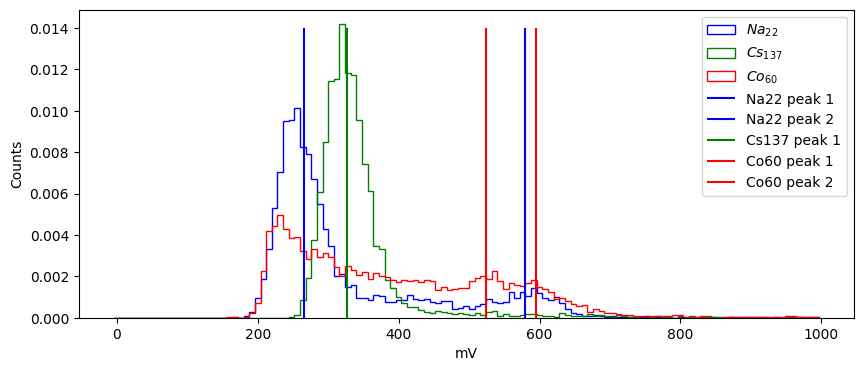

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(na22_data['mV'], bins=bins, density=True, range=(0, 1000), histtype='step', label=r'$Na_{22}$', color='blue')
ax.hist(cs137_data['mV'], bins=bins, density=True, range=(0, 1000), histtype='step', label=r'$Cs_{137}$', color= 'green')
ax.hist(co60_data['mV'], bins=bins, density=True, range=(0, 1000), histtype='step', label=r'$Co_{60}$', color = 'red')
vline_height=0.014
plt.vlines(first_peak_na22[0], 0, vline_height, color='blue', label='Na22 peak 1')
plt.vlines(second_peak_na22[0], 0, vline_height, color='blue', label='Na22 peak 2')
plt.vlines(first_peak_cs137[0], 0, vline_height, color='green', label='Cs137 peak 1')
plt.vlines(first_peak_co60[0], 0, vline_height, color='red', label='Co60 peak 1')
plt.vlines(second_peak_co60[0], 0, vline_height, color='red', label='Co60 peak 2')


ax.set_xlabel('mV')
ax.set_ylabel('Counts')
ax.legend()



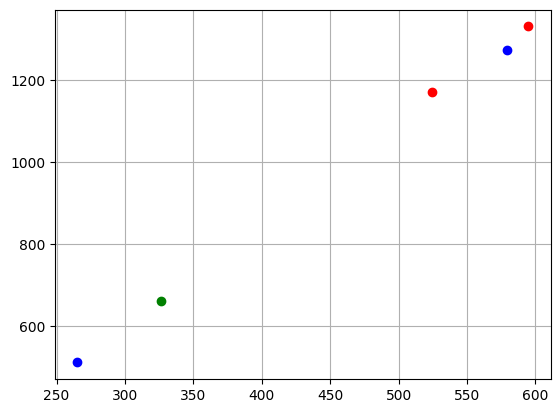

In [49]:
# sodium peak at 511 and 1275 KeV
plt.scatter(first_peak_na22[0], 511, color='blue')
plt.scatter(second_peak_na22[0], 1275, color='blue')
# cesium peak at 662 KeV
plt.scatter(first_peak_cs137[0], 662, color='green')
# cobalt peak at 1173 and 1332 KeV
plt.scatter(first_peak_co60[0], 1173, color='red')
plt.scatter(second_peak_co60[0], 1332, color='red')
plt.grid()
